### Def

In [59]:
%run '../definitions.ipynb'
%run 'XAMSraw.ipynb'

### Settings

In [60]:
# Warm data
# dset900 = '170313_101924'
# dset850 = '170313_102507'

# Just before data
dset900 = '170323_103732'
dset850 = '170323_104831'

# Just after data (baseline issues?)
# dset900 = '170327_143657'
# dset850 = '170327_144150'

# Latest data (PMT2 has lots of ringing)
# dset900 = '170404_114542'
# dset850 = '170404_115739'

gain_900_0 = 2379128.143411107
gain_850_1 = 2561006.625638467

In [61]:
# Settings
begrenzer = 1000
dset = dset900
gain = gain_900_0
channel = 0

baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

### Channel zero (PMT2)

In [66]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')

In [67]:
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)

100%|██████████| 1000/1000 [00:00<00:00, 1502.48it/s]


In [68]:
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:05<00:00, 171.21it/s]


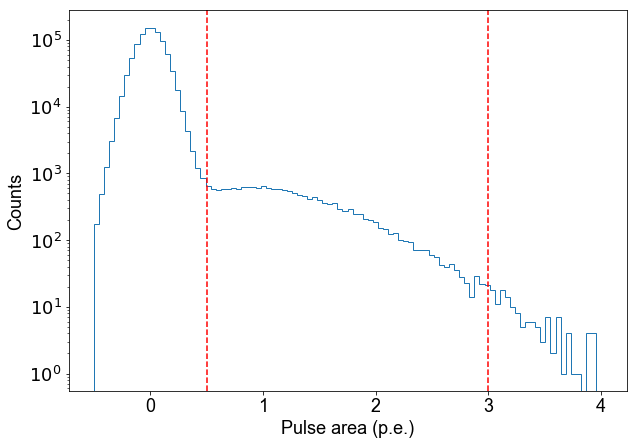

In [69]:
x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=100, histtype='step', range=(-0.5, 4))

In [70]:
x.cut_area(area_cut_bounds)

Selected 17136 of 1000000 events (1.71 %)


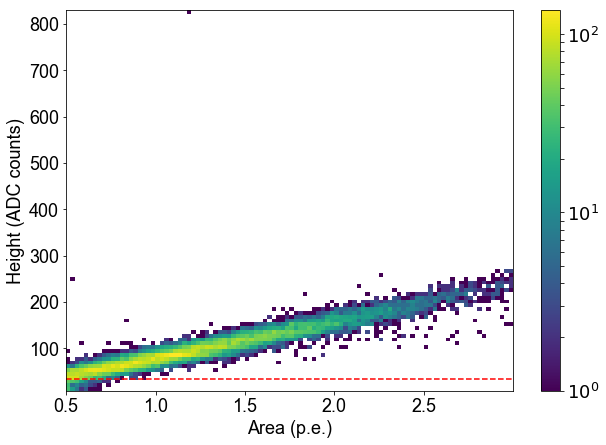

In [71]:
x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
plt.show()

In [72]:
x.cut_max((min_amplitude, 10000))

Selected 16781 of 17136 events (97.93 %)


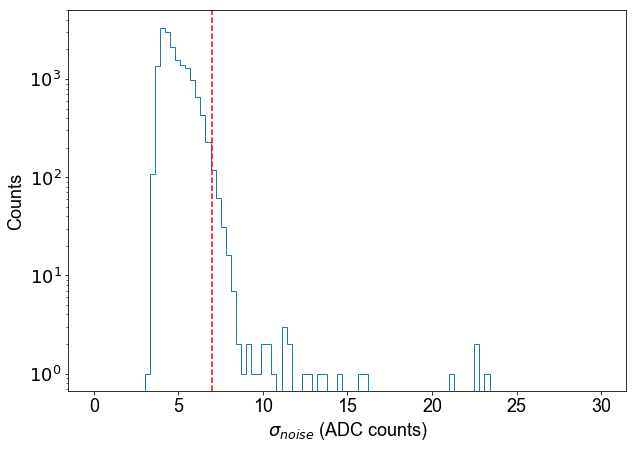

In [73]:
x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
plt.show()

In [74]:
x.cut_noise(noise_max)

Selected 16557 of 16781 events (98.67 %)


In [75]:
x.load_waveforms()
x.process(baseline_left, baseline_right, area_bounds, gain_900_0)

100%|██████████| 1000/1000 [00:53<00:00, 17.50it/s]


In [76]:
t, pulse = x.get_average_pulse()

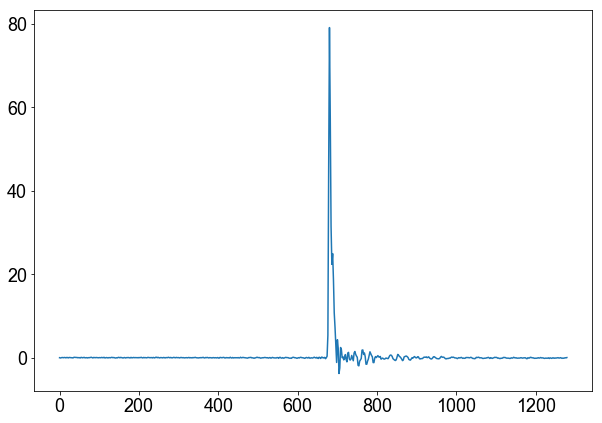

In [77]:
plt.plot(t, pulse)

### The single electron gain spread function

In [78]:
def gaus(x, mu, sigma):
    return np.exp( - (x - mu)**2 / (2 * sigma**2))

def gaus_trunc(x, mu, sigma):
    return (x > 0) * np.exp( - (x - mu)**2 / (2 * sigma**2))

#### Channel 0

In [85]:
# Settings
begrenzer = 1000
dset = dset900
gain = gain_900_0
channel = 0

In [86]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:05<00:00, 181.09it/s]


(0, 1000)

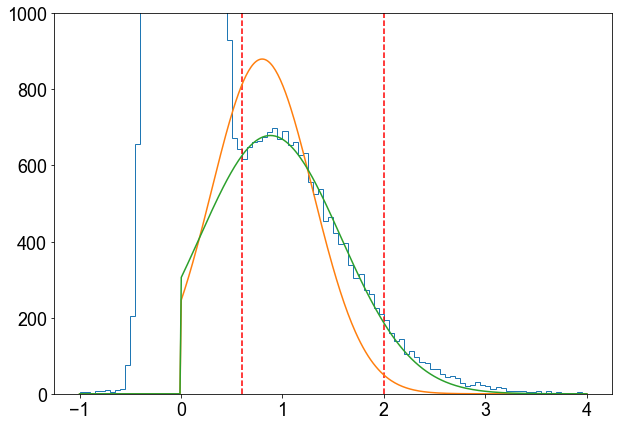

In [87]:
popt, perr, _ , _ = fit_unbinned(x.df['area'], gaus_trunc, (0.8,0.5), plot=True, fit_range=(0.6, 2.), 
                                plot_range=(-1, 4), print_level=0)
plt.ylim(0, 1000)

In [88]:
norm = integrate(gaus_trunc, popt, -1, 4, 1000)
def to_int(x, mu, sigma):
    return x * gaus_trunc(x, mu, sigma)
intxfdx = integrate(to_int, popt, -1, 4, 1000)
print('Gain ratio: ', intxfdx / norm)

Gain ratio:  1.01955116473


In [89]:
pickle.dump((norm, popt, perr), open(x.run_name + '_ch%d_function.pickle' % x.channel, 'wb'))

#### Channel 1

In [90]:
# Settings
begrenzer = 1000
dset = dset850
gain = gain_850_1
channel = 1

In [91]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:12<00:00, 77.37it/s]


(0, 1000)

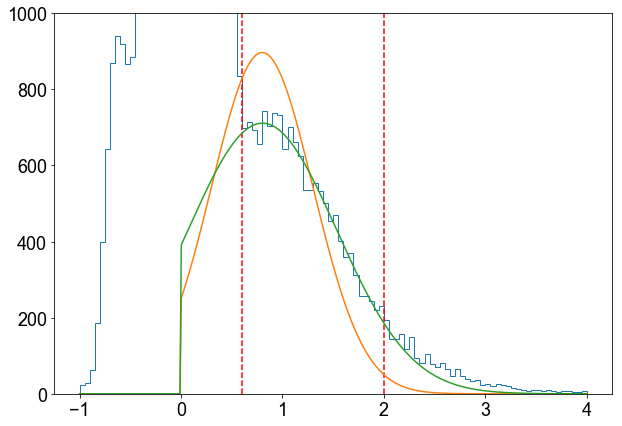

In [92]:
popt, perr, _ , _ = fit_unbinned(x.df['area'], gaus_trunc, (0.8,0.5), plot=True, fit_range=(0.6, 2.), 
                                plot_range=(-1, 4), print_level=0)
plt.ylim(0, 1000)

In [95]:
norm = integrate(gaus_trunc, popt, -1, 4, 1000)
def to_int(x, mu, sigma):
    return x * gaus_trunc(x, mu, sigma)
intxfdx = integrate(to_int, popt, -1, 4, 1000)
print('Gain ratio: ', intxfdx / norm)

Gain ratio:  0.986878711044


In [96]:
pickle.dump((norm, popt, perr), open(x.run_name + '_ch%d_function.pickle' % x.channel, 'wb'))

### Compute average pulse for all datasets and channels

#### Definition of main function

In [118]:
def load_all(dset, channel, gain, area_bounds, area_cut_bounds,
             baseline_left, baseline_right, stop_after = 1000, plot = False):
    x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms/')
    x.process_all(stop_after, baseline_left, baseline_right, area_bounds, gain)
    x.load_processed(stop_after)
    # Cuts
    # Area
    if plot:
        x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=100, histtype='step', range=(-0.5, 4))
        plt.show()
    x.cut_area(area_cut_bounds)
    # Heigth
    if plot:
        x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
        plt.show()
    x.cut_max((min_amplitude, 10000))
    # Noise
    if plot:
        x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
        plt.show()
    x.cut_noise(noise_max)
    
    # Load waveforms, process, and compute average
    x.load_waveforms()
    x.process(baseline_left, baseline_right, area_bounds, gain)
    t, pulse = x.get_average_pulse()
    
    pickle.dump(pulse, open('%s_ch%d.pickle' % (dset, channel) , 'wb'))
    return x, t, pulse

#### General settings

In [163]:
# All cold datasets, perhaps the last one suffers from Rn? Have to check warm datasets?
datasets = [
  [
    # Ch 0 (900 V)
    # '170313_101924' # warm
    '170313_101924',
    '170323_103732',
    '170327_143657',
    '170404_114542'
  ],
  [
    # Ch 1 (850 V)
    # '170313_102507' # warm
    '170313_102507',
    '170323_104831',
    '170327_144150',
    '170404_115739'
  ]
]

# gain by channel
gains = [2379128.143411107, 2561006.625638467]


In [164]:
# Settings
baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

In [167]:
sure = True

if sure == True:
    for channel in [1]:
        gain = gains[channel]
        for dset in datasets[channel]:
            print(dset)
            _ = load_all(dset, channel, gain, area_bounds, area_cut_bounds,
                 baseline_left, baseline_right, stop_after = 1000, plot = False)


  0%|          | 0/1000 [00:00<?, ?it/s]

170313_102507



100%|██████████| 1000/1000 [00:10<00:00, 98.51it/s]


Selected 50198 of 1000000 events (5.02 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 49776 of 50198 events (99.16 %)
Selected 48952 of 49776 events (98.34 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170323_104831


100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s]


Selected 18272 of 1000000 events (1.83 %)
Selected 17270 of 18272 events (94.52 %)
Selected 16906 of 17270 events (97.89 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170327_144150


100%|██████████| 1000/1000 [00:16<00:00, 59.17it/s]


Selected 18753 of 1000000 events (1.88 %)


  0%|          | 1/1000 [00:00<01:59,  8.37it/s]

Selected 15640 of 18753 events (83.40 %)
Selected 15229 of 15640 events (97.37 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170404_115739


100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s]


Selected 39091 of 1000000 events (3.91 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 38527 of 39091 events (98.56 %)
Selected 38348 of 38527 events (99.54 %)


100%|██████████| 1000/1000 [01:07<00:00, 15.04it/s]


### Read all average waveforms and compare

In [126]:
t = np.linspace(0, 639*2, 640)

#### Channel 0

In [168]:
channel = 0

In [169]:
# Read
pulses_ch0 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch0.append(pulse)

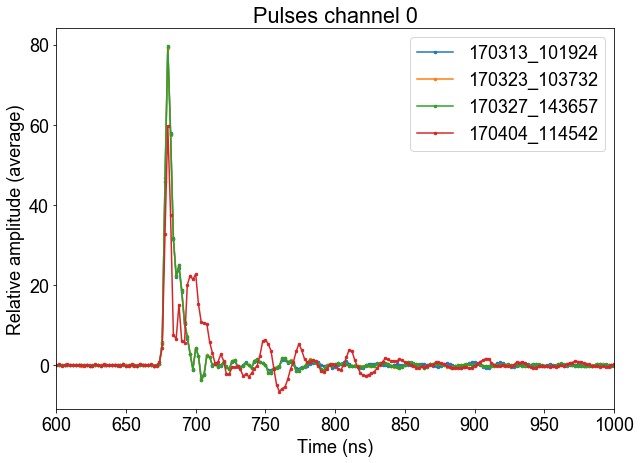

In [170]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

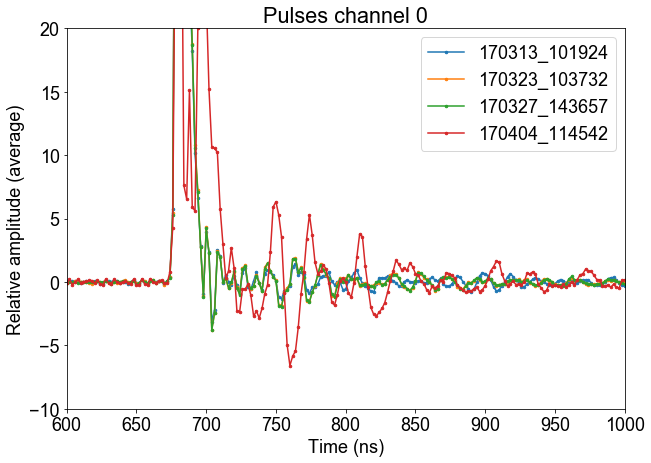

In [171]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 20)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

#### Channel 1

In [172]:
channel = 1

In [173]:
# Read
pulses_ch1 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch1.append(pulse)

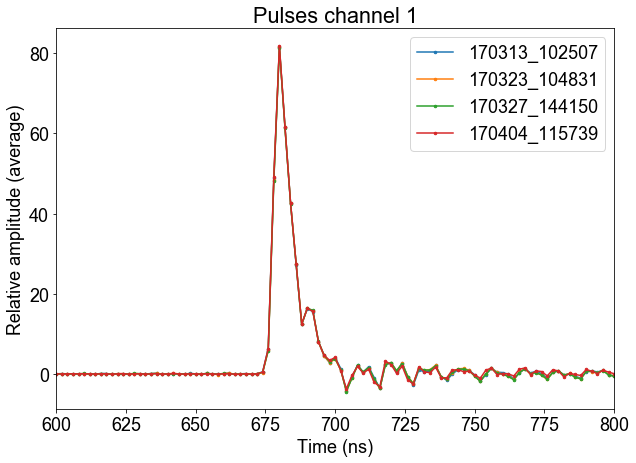

In [174]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 800)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

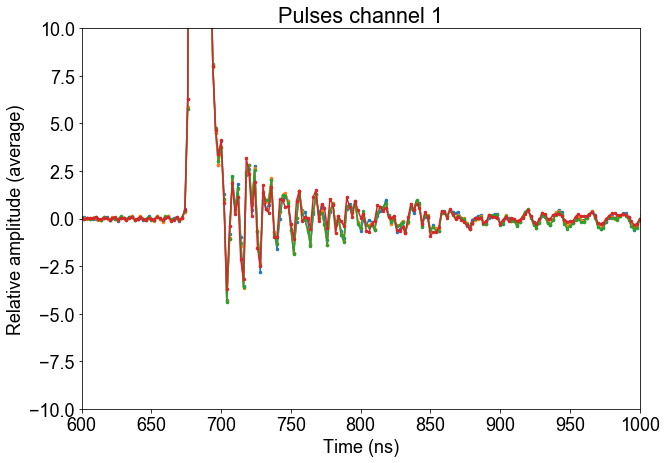

In [175]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 10)
plt.title('Pulses channel %d' % channel)
plt.show()

In [149]:
pulse_ch0 = pulses_ch0[1]
pulse_ch1 = pulses_ch1[1]

(600, 800)

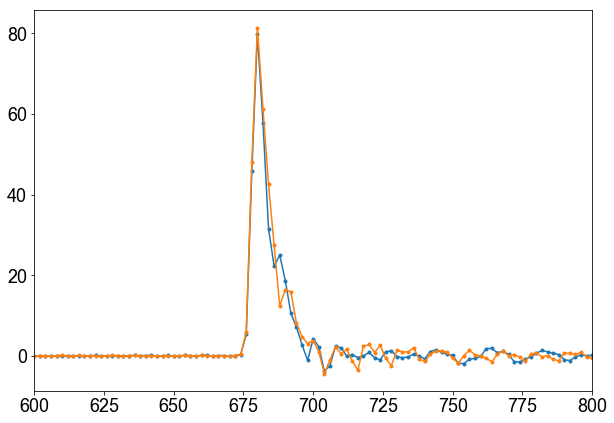

In [150]:
plt.plot(t, pulse_ch0, marker='.')
plt.plot(t, pulse_ch1, marker='.')
plt.xlim(600, 800)

### Area scan

Selected 2876 of 15643 events (18.4 %)
Selected 3270 of 15643 events (20.9 %)
Selected 2970 of 15643 events (19.0 %)
Selected 2348 of 15643 events (15.0 %)
Selected 1668 of 15643 events (10.7 %)
Selected 1142 of 15643 events (7.3 %)
Selected 665 of 15643 events (4.3 %)
Selected 381 of 15643 events (2.4 %)
Selected 210 of 15643 events (1.3 %)
Selected 113 of 15643 events (0.7 %)


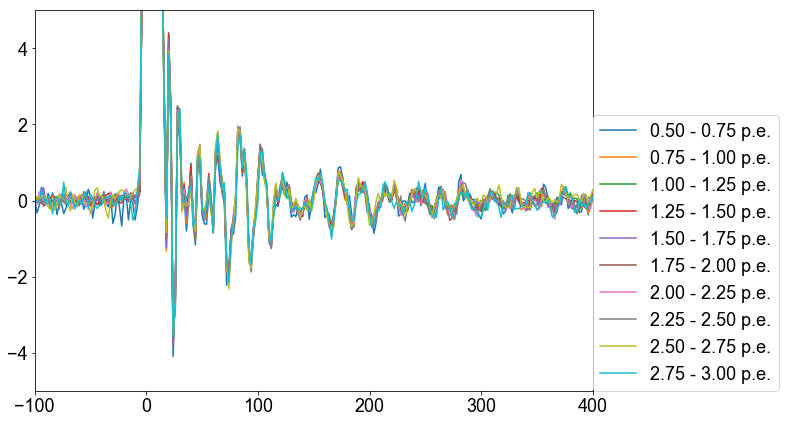

In [26]:
nbins = 11
area_bin_edges = np.linspace(*area_cut_bounds, num=nbins)
for area_min, area_max in zip(area_bin_edges[:-1], area_bin_edges[1:]):
    _x = deepcopy(x)
    _x.cut_area(channel, (area_min, area_max))
    _time, _pulse = _x.get_average_pulse(0, normalize=True, align_on='max_index', alignment_bin=340)
    plt.plot(_time - 340 * 2, _pulse, label='%.2f - %.2f p.e.' % (area_min, area_max))
plt.legend(loc=(1,0))
plt.xlim(-100, 400)
plt.ylim(-5, 5)
plt.show()

### Channel 1 (PMT1)

### To check out:

  * Per dataset
  * For different area slices (Looks good!)
  * Jackknife?
  * FFT

In [153]:
from IPython.display import display, Javascript
display(Javascript("""
require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
            title: 'Hello world',
            body: 'Hi, lorem ipsum and such',
            buttons: {
                'kthxbye': {}
            }
        });
    }
);
"""))

<IPython.core.display.Javascript object>